### Стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
### Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
### После этого исследуйте результаты A/A/B-эксперимента. 

### Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. 
### Договорились принять решение по результатам A/A/B-теста. 
### Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 
### Выясните, какой шрифт лучше.

### Описание данных
### Каждая запись в логе — это действие пользователя, или событие.
* #### EventName — название события;
* #### DeviceIDHash — уникальный идентификатор пользователя;
* #### EventTimestamp — время события;
* #### ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
from plotly import graph_objects as go
from datetime import date, timedelta
import warnings
import seaborn as sns
from scipy.stats import ttest_ind
warnings.filterwarnings("ignore")

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
dataframe = pd.read_csv("./data/logs_exp.csv", "\t")

In [3]:
dataframe.head(10)

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
5         CartScreenAppear  6217807653094995999      1564055323    248
6       OffersScreenAppear  8351860793733343758      1564066242    246
7         MainScreenAppear  5682100281902512875      1564085677    246
8         MainScreenAppear  1850981295691852772      1564086702    247
9         MainScreenAppear  5407636962369102641      1564112112    246

In [4]:
# Описательная статистика
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
dataframe.describe(percentiles=percentiles)

DeviceIDHash  EventTimestamp          ExpId
count  2.441260e+05    2.441260e+05  244126.000000
mean   4.627568e+18    1.564914e+09     247.022296
std    2.642425e+18    1.771343e+05       0.824434
min    6.888747e+15    1.564030e+09     246.000000
1%     1.062560e+17    1.564611e+09     246.000000
5%     4.558124e+17    1.564652e+09     246.000000
10%    9.289858e+17    1.564670e+09     246.000000
25%    2.372212e+18    1.564757e+09     246.000000
50%    4.623192e+18    1.564919e+09     247.000000
75%    6.932517e+18    1.565075e+09     248.000000
90%    8.247594e+18    1.565166e+09     248.000000
95%    8.746336e+18    1.565189e+09     248.000000
99%    9.135270e+18    1.565205e+09     248.000000
max    9.222603e+18    1.565213e+09     248.000000

In [5]:
# Корреляционная матрица
dataframe.corr()

DeviceIDHash  EventTimestamp     ExpId
DeviceIDHash        1.000000       -0.018575  0.016081
EventTimestamp     -0.018575        1.000000 -0.019575
ExpId               0.016081       -0.019575  1.000000

In [6]:
# Количество дубликатов
dataframe.duplicated().sum()

413

# Шаг 2. Подготовьте данные

* Замените названия столбцов на удобные для вас;

* Проверьте пропуски и типы данных. Откорректируйте, если нужно;

* Добавьте столбец даты и времени, а также отдельный столбец дат;

In [7]:
# Замените названия столбцов на удобные для вас;
dataframe.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_time_stamp',
    'ExpId': 'id_exp'
}, inplace=True)

In [8]:
dataframe

event_name            device_id  event_time_stamp  id_exp
0              MainScreenAppear  4575588528974610257        1564029816     246
1              MainScreenAppear  7416695313311560658        1564053102     246
2       PaymentScreenSuccessful  3518123091307005509        1564054127     248
3              CartScreenAppear  3518123091307005509        1564054127     248
4       PaymentScreenSuccessful  6217807653094995999        1564055322     248
...                         ...                  ...               ...     ...
244121         MainScreenAppear  4599628364049201812        1565212345     247
244122         MainScreenAppear  5849806612437486590        1565212439     246
244123         MainScreenAppear  5746969938801999050        1565212483     246
244124         MainScreenAppear  5746969938801999050        1565212498     246
244125       OffersScreenAppear  5746969938801999050        1565212517     246

[244126 rows x 4 columns]

In [9]:
# Проверьте пропуски и типы данных. Откорректируйте, если нужно;
dataframe.isna().sum()

event_name          0
device_id           0
event_time_stamp    0
id_exp              0
dtype: int64

In [10]:
dataframe.dtypes

event_name          object
device_id            int64
event_time_stamp     int64
id_exp               int64
dtype: object

In [11]:
# Добавьте столбец даты и времени, а также отдельный столбец дат;
dataframe['date_time'] = pd.to_datetime(dataframe['event_time_stamp'], unit='s')

In [12]:
dataframe['date'] = [d.date() for d in dataframe['date_time']]
dataframe['time'] = [d.time() for d in dataframe['date_time']]

In [13]:
dataframe

event_name            device_id  event_time_stamp  \
0              MainScreenAppear  4575588528974610257        1564029816   
1              MainScreenAppear  7416695313311560658        1564053102   
2       PaymentScreenSuccessful  3518123091307005509        1564054127   
3              CartScreenAppear  3518123091307005509        1564054127   
4       PaymentScreenSuccessful  6217807653094995999        1564055322   
...                         ...                  ...               ...   
244121         MainScreenAppear  4599628364049201812        1565212345   
244122         MainScreenAppear  5849806612437486590        1565212439   
244123         MainScreenAppear  5746969938801999050        1565212483   
244124         MainScreenAppear  5746969938801999050        1565212498   
244125       OffersScreenAppear  5746969938801999050        1565212517   

        id_exp           date_time        date      time  
0          246 2019-07-25 04:43:36  2019-07-25  04:43:36  
1          246 2019-07-25 11:11:42  2019-07-25  11:11:42  
2          248 2019-07-25 11:28:47  2019-07-25  11:28:47  
3          248 2019-07-25 11:28:47  2019-07-25  11:28:47  
4          248 2019-07-25 11:48:42  2019-07-25  11:48:42  
...        ...                 ...         ...       ...  
244121     247 2019-08-07 21:12:25  2019-08-07  21:12:25  
244122     246 2019-08-07 21:13:59  2019-08-07  21:13:59  
244123     246 2019-08-07 21:14:43  2019-08-07  21:14:43  
244124     246 2019-08-07 21:14:58  2019-08-07  21:14:58  
244125     246 2019-08-07 21:15:17  2019-08-07  21:15:17  

[244126 rows x 7 columns]

# Шаг 3. Изучите и проверьте данные

* Сколько всего событий в логе?

* Сколько всего пользователей в логе?

* Сколько в среднем событий приходится на пользователя?

* Данными за какой период вы располагаете? 

* Найдите максимальную и минимальную дату.

* Постройте гистограмму по дате и времени.

* Можно ли быть уверенным, что у вас одинаково полные данные за весь период?

* Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

* Определите, с какого момента данные полные и отбросьте более старые.

* Данными за какой период времени вы располагаете на самом деле?

* Много ли событий и пользователей вы потеряли, отбросив старые данные?

* Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [14]:
# Сколько всего событий в логе?
print(f"Всего записей: {dataframe.shape[0]}\nУникальных событий: {len(dataframe['event_name'].unique())}")

Всего записей: 244126
Уникальных событий: 5


In [15]:
# Сколько всего пользователей в логе?
print(f"Уникальных девайсов пользователей: {len(dataframe['device_id'].unique())}")

Уникальных девайсов пользователей: 7551


In [16]:
# Сколько в среднем событий приходится на пользователя?
print(f"Событий в среднем на пользователя {round(dataframe.groupby('device_id')['event_name'].count().mean())}")

Событий в среднем на пользователя 32


In [17]:
# Данными за какой период вы располагаете?
print(f"Записи сделаны в период с {dataframe['date'].min()} по {dataframe['date'].max()}")
print(f"Дельта времени записей: {timedelta(seconds=dataframe['event_time_stamp'].max() - dataframe['event_time_stamp'].min())}")

Записи сделаны в период с 2019-07-25 по 2019-08-07
Дельта времени записей: 13 days, 16:31:41


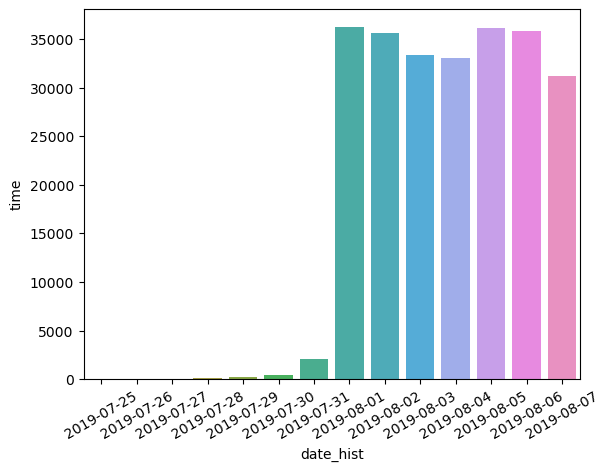

In [18]:
# Постройте гистограмму по дате и времени.
dataframe["date_hist"] = dataframe["date"].astype("datetime64")
hist_date_time = sns.barplot(data=dataframe.groupby(dataframe["date_hist"].dt.date)["time"].count().reset_index(), x="date_hist", y="time")
for item in hist_date_time.get_xticklabels():
    item.set_rotation(30)

### Можно ли быть уверенным, что у вас одинаково полные данные за весь период?

**Исходя из диаграммы соотношения даты и количества записей времени, можно сделать вывод, что полные данные содержаться начиная с 01/08/2019**

In [19]:
dataframe = dataframe.loc[dataframe["date"] >= date(year=2019, month=8, day=1)]
dataframe

event_name            device_id  event_time_stamp  id_exp  \
2828              Tutorial  3737462046622621720        1564618048     246   
2829      MainScreenAppear  3737462046622621720        1564618080     246   
2830      MainScreenAppear  3737462046622621720        1564618135     246   
2831    OffersScreenAppear  3737462046622621720        1564618138     246   
2832      MainScreenAppear  1433840883824088890        1564618139     247   
...                    ...                  ...               ...     ...   
244121    MainScreenAppear  4599628364049201812        1565212345     247   
244122    MainScreenAppear  5849806612437486590        1565212439     246   
244123    MainScreenAppear  5746969938801999050        1565212483     246   
244124    MainScreenAppear  5746969938801999050        1565212498     246   
244125  OffersScreenAppear  5746969938801999050        1565212517     246   

                 date_time        date      time  date_hist  
2828   2019-08-01 00:07:28  2019-08-01  00:07:28 2019-08-01  
2829   2019-08-01 00:08:00  2019-08-01  00:08:00 2019-08-01  
2830   2019-08-01 00:08:55  2019-08-01  00:08:55 2019-08-01  
2831   2019-08-01 00:08:58  2019-08-01  00:08:58 2019-08-01  
2832   2019-08-01 00:08:59  2019-08-01  00:08:59 2019-08-01  
...                    ...         ...       ...        ...  
244121 2019-08-07 21:12:25  2019-08-07  21:12:25 2019-08-07  
244122 2019-08-07 21:13:59  2019-08-07  21:13:59 2019-08-07  
244123 2019-08-07 21:14:43  2019-08-07  21:14:43 2019-08-07  
244124 2019-08-07 21:14:58  2019-08-07  21:14:58 2019-08-07  
244125 2019-08-07 21:15:17  2019-08-07  21:15:17 2019-08-07  

[241298 rows x 8 columns]

In [20]:
print(f"Записи сделаны в период с {dataframe['date'].min()} по {dataframe['date'].max()}")
print(f"Дельта времени записей: {timedelta(seconds=dataframe['event_time_stamp'].max() - dataframe['event_time_stamp'].min())}")

Записи сделаны в период с 2019-08-01 по 2019-08-07
Дельта времени записей: 6 days, 21:07:49


In [21]:
dataframe.groupby(dataframe["id_exp"])["id_exp"].count()

id_exp
246    79425
247    77147
248    84726
Name: id_exp, dtype: int64

# Шаг 4. Изучите воронку событий

* Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

* Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

* Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

* По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

* На каком шаге теряете больше всего пользователей?

* Какая доля пользователей доходит от первого события до оплаты?

In [22]:
# Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
dataframe["event_name"].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

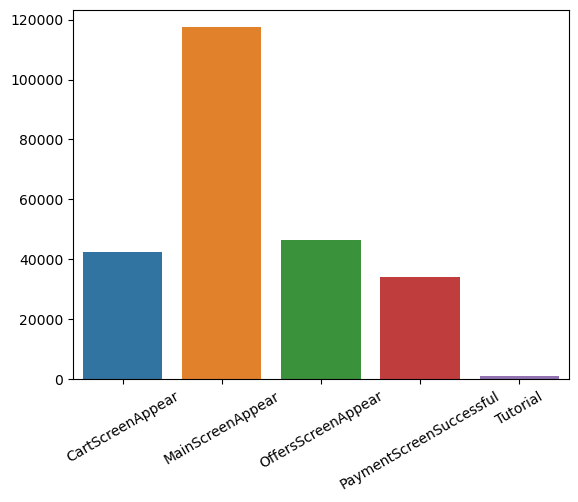

In [23]:
x, y = [], []
for el, el1 in dataframe.groupby(dataframe["event_name"])["event_name"].count().items():
    x.append(el)
    y.append(el1)

hist_event = sns.barplot(x=x, y=y)
for item in hist_event.get_xticklabels():
    item.set_rotation(30)

In [24]:
# Посчитайте, сколько пользователей совершали каждое из этих событий.
df2 = dataframe.groupby(dataframe["event_name"])["device_id"].nunique().reset_index().sort_values(by=['device_id'], ascending=False)
df2

event_name  device_id
1         MainScreenAppear       7419
2       OffersScreenAppear       4593
0         CartScreenAppear       3734
3  PaymentScreenSuccessful       3539
4                 Tutorial        840

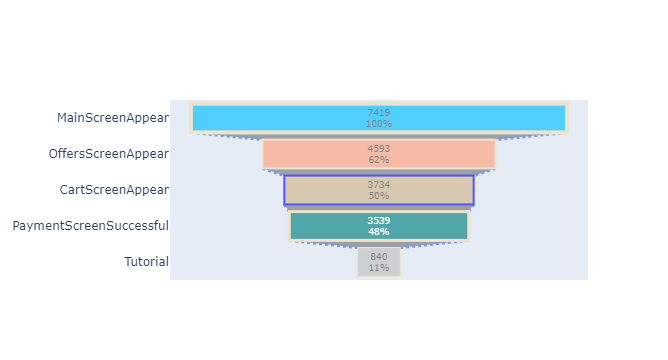

In [25]:
# Отсортируйте события по числу пользователей.
# Посчитайте долю пользователей, которые хоть раз совершали событие.
fig = go.Figure(go.Funnel(
    y = df2["event_name"],
    x = df2["device_id"],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show()

### Предположите, в каком порядке происходят события

**Имеется предположение:**

1. MainScreenAppear

1. OffersScreenAppear

1. CartScreenAppear

1. PaymentScreenSuccessful

---

### Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

**Tutorial нет необъодимости включать в воронку**

In [26]:
'''
По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A,
а также отношение числа пользователей с событием C к количеству пользователей с событием B.
'''
a = []
for i in range(df2.shape[0]-1):
    a.append(df2.iloc[i].device_id)

for i in range(1, len(a)):
    print(f"{df2.iloc[i-1].event_name} -> {df2.iloc[i].event_name} : {round(a[i]/a[i-1] * 100, 2)}%")

MainScreenAppear -> OffersScreenAppear : 61.91%
OffersScreenAppear -> CartScreenAppear : 81.3%
CartScreenAppear -> PaymentScreenSuccessful : 94.78%


**Как видно из процентного соотношения, больше всего потерь между MainScreenAppear и OffersScreenAppear**

In [27]:
# Какая доля пользователей доходит от первого события до оплаты?
print(f"{df2.iloc[0].event_name} -> {df2.iloc[3].event_name} : {round(a[3] / a[0] * 100, 2)}%")

MainScreenAppear -> PaymentScreenSuccessful : 47.7%


# Шаг 5. Изучите результаты эксперимента

* Сколько пользователей в каждой экспериментальной группе?

* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

* Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

* Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

* Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [28]:
# Сколько пользователей в каждой экспериментальной группе?
# 246 и 247 — контрольные группы, а 248 — экспериментальная.
df3 = dataframe.groupby(dataframe["id_exp"])["device_id"].nunique().reset_index().sort_values(by=['id_exp'])
df3.rename(columns={
    'device_id': 'count_un_users',
}, inplace=True)
df3

id_exp  count_un_users
0     246            2484
1     247            2513
2     248            2537

In [43]:
# Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.
# Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
from scipy.stats import norm
# 436 страница Кобзарь А.И. Прикладная математическая статистика
# Таблица квантилей стр 26


def z_test(gr_1: int, gr_2: int, event: str, double=False, a=0.05):
    if double:
        df3_only_MainScreenAppear = dataframe[dataframe["event_name"] == event].groupby(dataframe["id_exp"])["device_id"].nunique().reset_index().sort_values(by=['id_exp'])
        group_all_246 = df3.iloc[gr_1 % 246].count_un_users
        group_all_247 = df3.iloc[gr_2 % 246].count_un_users
        event_only_246 = df3_only_MainScreenAppear.iloc[gr_1 % 246].device_id
        event_only_247 = df3_only_MainScreenAppear.iloc[gr_2 % 246].device_id
        # print(f"{gr_1} и {gr_2}")
    else:
        df3_only_MainScreenAppear = dataframe[dataframe["event_name"] == event].groupby(dataframe["id_exp"])["device_id"].nunique().reset_index().sort_values(by=['id_exp'])
        group_all_246 = df3.iloc[0].count_un_users + df3.iloc[1].count_un_users
        group_all_247 = df3.iloc[gr_2 % 246].count_un_users
        event_only_246 = df3_only_MainScreenAppear.iloc[0].device_id + df3_only_MainScreenAppear.iloc[1].device_id
        event_only_247 = df3_only_MainScreenAppear.iloc[gr_2 % 246].device_id
        # print("Группы 246+247 и 248")

    shares_246 = (event_only_246 / group_all_246) + (1 / (2 * group_all_246))
    shares_247 = (event_only_247 / group_all_247) + (1 / (2 * group_all_247))
    denominator = (((event_only_246 + event_only_247) / (group_all_246 + group_all_247)) * ((group_all_246 + group_all_247 - event_only_246 - event_only_247) / (group_all_246 + group_all_247)) * ((1 / group_all_246) + (1 / group_all_247))) ** (1/2)
    u = norm.ppf(((2 - a) / 2), 0, 1)
    z = (shares_246 - shares_247) / denominator

    if (z < u):
        print("Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы")
    else:
        print("Отвергаем нулевую гипотезу -> между долями ЕСТЬ значимая разница")

for el in dataframe["event_name"].unique():
    print(el)
    z_test(246, 247, el)
    print("-" * 50)

Tutorial
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
--------------------------------------------------
MainScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
--------------------------------------------------
OffersScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
--------------------------------------------------
CartScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
--------------------------------------------------
PaymentScreenSuccessful
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
--------------------------------------------------


In [44]:
# Выберите самое популярное событие.
df4 = dataframe.groupby(dataframe["event_name"])["device_id"].nunique().reset_index().sort_values(by=['device_id'], ascending=False).iloc[0]
print(f"{df4.event_name} : {df4.device_id}")

MainScreenAppear : 7419


In [45]:
# Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп
df5 = dataframe[dataframe['event_name']=='MainScreenAppear'].groupby(dataframe["id_exp"])["device_id"].nunique().reset_index().sort_values(by=['device_id'], ascending=False)
df5

id_exp  device_id
2     248       2493
1     247       2476
0     246       2450

In [46]:
# Посчитайте долю пользователей, совершивших это событие.
df6 = dataframe.groupby(dataframe["id_exp"])["device_id"].nunique().reset_index().sort_values(by=['id_exp'], ascending=False)
df5["device_id"] = df5["device_id"].div(df6["device_id"])
df5

id_exp  device_id
2     248   0.982657
1     247   0.985277
0     246   0.986312

In [47]:
# Проверьте, будет ли отличие между группами статистически достоверным.
def ind_test(id_exp_1, id_exp_2, event_name, a=0.05):
    group1 = dataframe[(dataframe['id_exp']==id_exp_1) & (dataframe['event_name']==event_name)]
    group2 = dataframe[(dataframe['id_exp']==id_exp_2) & (dataframe['event_name']==event_name)]
    statistic, pvalue = ttest_ind(group1['device_id'], group2['device_id'])
    
    print(f"{id_exp_1} и {id_exp_2}")
    if (abs(pvalue) < a):
        print("Отвергаем нулевую гипотезу -> между выборками ЕСТЬ значимая разница")
    else:
        print("Принимаем нулевую гипотезу -> между выборками НЕТ значимой разницы")

print("246 и 247")
z_test(246, 247, 'MainScreenAppear')
print("246 и 248")
z_test(246, 248, 'MainScreenAppear')
print("247 и 248")
z_test(247, 248, 'MainScreenAppear')

246 и 247
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
246 и 248
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
247 и 248
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы


In [48]:
# Проделайте то же самое для всех других событий
# Аналогично поступите с группой с изменённым шрифтом.
# Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.
for el in dataframe['event_name'].unique():
    print(el)
    z_test(246, 247, el)
    z_test(246, 248, el)
    z_test(247, 248, el)
    print("-" * 100)

Tutorial
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
MainScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
OffersScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
CartScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой раз

### Можно ли сказать, что разбиение на группы работает корректно?

**С вероятность 95% можно утверждать, что разбиение на группы работает корректно**

In [49]:
# Сравните результаты с объединённой контрольной группой.
for el in dataframe['event_name'].unique():
    print(el)
    z_test(246+247, 248, el, True)
    print("-" * 100)

Tutorial
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
MainScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
OffersScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
CartScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
PaymentScreenSuccessful
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------


In [53]:
'''
Какой уровень значимости вы выбрали при проверке статистических гипотез выше?
Посчитайте, сколько проверок статистических гипотез вы сделали.
При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.
Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.
'''
a = 0.01
for el in dataframe['event_name'].unique():
    print(el)
    z_test(246, 247, el, a=a)
    z_test(246, 248, el, a=a)
    z_test(247, 248, el, a=a)
    print("-" * 100)

Tutorial
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
MainScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
OffersScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
CartScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой раз

In [54]:
for el in dataframe['event_name'].unique():
    print(el)
    z_test(246+247, 248, el, True, a)
    print("-" * 100)

Tutorial
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
MainScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
OffersScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
CartScreenAppear
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
PaymentScreenSuccessful
Принимаем нулевую гипотезу -> между долями НЕТ значимой разницы
----------------------------------------------------------------------------------------------------
